Notebook for testing nn performance

In [1]:
# import dependencies
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from data_preprocessing import extract_csv_info, format_data, shuffle_and_split, split_input_output, extract_csv_info_datasets_folder, format_data_preisach
from neural import train_and_generate_feedforward_network, train_and_generate_recurrent_network, train_and_generate_preisach_network, train_and_generate_recurrent_preisach_network, compile_recurrent_preisach_network_without_training

In [12]:
# Function to compute MSE of predicted values
def compute_mse(actual_y, predicted_y):
    actual_y = np.asarray(actual_y)
    predicted_y = np.asarray(predicted_y)
    diff = np.subtract(actual_y, predicted_y)
    squared = np.square(diff)
    mse = np.mean(squared)
    return mse

# test compute mse
# y = [11, 20, 19, 17, 10]
# y_pred = [12, 18, 19.5, 18, 9]
# print(compute_mse(y, y_pred))

In [2]:
# Function for plotting predicted values from NN
# TODO: add figsize and xlim as input to function to allow customization
def plot_predicted(next_h, next_b, model_name):
    plt.figure(figsize=(20, 12))
    plt.xlim(-750, 750)
    plt.plot(next_h, next_b, marker="o", color='black')
    plt.title(model_name + " Output Plot")
    plt.xlabel("Magnetic Field H (T)")
    plt.ylabel("Magnetic Flux B (A/m)")
    plt.show()


In [3]:
# Use to generate matching plots for poster
def poster_plot(x, actual_y, predicted_y, plot_title, save_name):
    figure = plt.figure(figsize=(14,10))
    plt.plot(x, actual_y, linestyle='--', marker='.', color='blue', label='actual', markersize=8, linewidth=1)
    plt.plot(x, predicted_y, linestyle='--', marker='.', color='red', label='predicted', markersize=8, linewidth=1)
    #plt.scatter(np.transpose(xtest_m19)[2], m19_pred, s=2)
    #plt.xlim(-500, 500)

    plt.xlabel("Magnetic Field H (A/m)", fontsize=22)
    plt.ylabel("Magnetic Flux B (T)", fontsize=22)
    #plt.title("Preisach Neural Network Prediction Results", fontsize=24)
    plt.title(plot_title, fontsize=30)

    plt.legend(loc=2, prop={'size': 24})
    plt.show()

    figure.savefig('./figures/' + save_name, dpi=400)

## Data Loading and Preprocessing

In [4]:
# Load data for training
raw_train_data = extract_csv_info_datasets_folder("./datasets/HB_Comb.csv")
formatted_data_3_in_1_out = format_data(raw_train_data)
train_x, train_y = split_input_output(formatted_data_3_in_1_out)

# Load data for training Preisach NN
p_train_x, p_train_y = format_data_preisach(raw_train_data)
p_train_x = np.reshape(np.array(p_train_x), (len(p_train_x), 1))
p_train_y = np.reshape(np.array(p_train_y), (len(p_train_y), 1))
#print(raw_train_data)
#print(train_x)
#print(train_y)

In [5]:
# Load data for testing
raw_test_data = extract_csv_info_datasets_folder("./datasets/HB1.csv")
formatted_test_data = format_data(raw_test_data)
test_x, test_y = split_input_output(formatted_test_data)

# Load data for testing Preisach NN
p_test_x, p_test_y = format_data_preisach(raw_test_data)
p_test_x_for_scaling = np.reshape(np.array(p_test_x), (len(p_test_x), 1))
#p_test_y_for_scaling = np.reshape(np.array(p_test_y), (len(p_test_y), 1))

# Separate next_h values into separate list for plotting output
test_next_h = list()
for i in range(len(test_x)):
    test_next_h.append(test_x[i][2])

## Recurrent Preisach NN


In [7]:
# Scale data
import sklearn
from sklearn.preprocessing import MinMaxScaler # for feature scaling

scaler = MinMaxScaler()
print(p_test_x_for_scaling.shape)
scaled_p_train_x = scaler.fit_transform(p_test_x_for_scaling, p_train_y)
#print(p_test_x.shape)
#scaled_p_test_x = scaler.fit_transform(p_test_x, p_test_y)

(3564, 1)
(1188, 1)


In [17]:
# Generate and train recurrent preisach network
n = 40
#rpnn_model = train_and_generate_recurrent_preisach_network(p_train_x[0:3552], p_train_y[0:3552], "recurrent_preisach.model", n_epochs=n)
rpnn_model = compile_recurrent_preisach_network_without_training("./models/rnn.model")
rpnn_model.fit(p_train_x[0:3552], p_train_y[0:3552], epochs=n, shuffle=False,
               validation_split=0.0)


Epoch 1/40
(32, 10)
(32, 10)
(32, 10)
111/111 [==============================] - 4s 2ms/step - loss: 1.1221 - mean_squared_error: 1.1221 - mean_absolute_error: 0.8810
Epoch 2/40
111/111 [==============================] - 0s 2ms/step - loss: 0.6773 - mean_squared_error: 0.6773 - mean_absolute_error: 0.7027

Output range of predicted loop should be bound between (-2, 2). Max should be something around 1.8
36/36 [==============================] - 0s 1ms/step


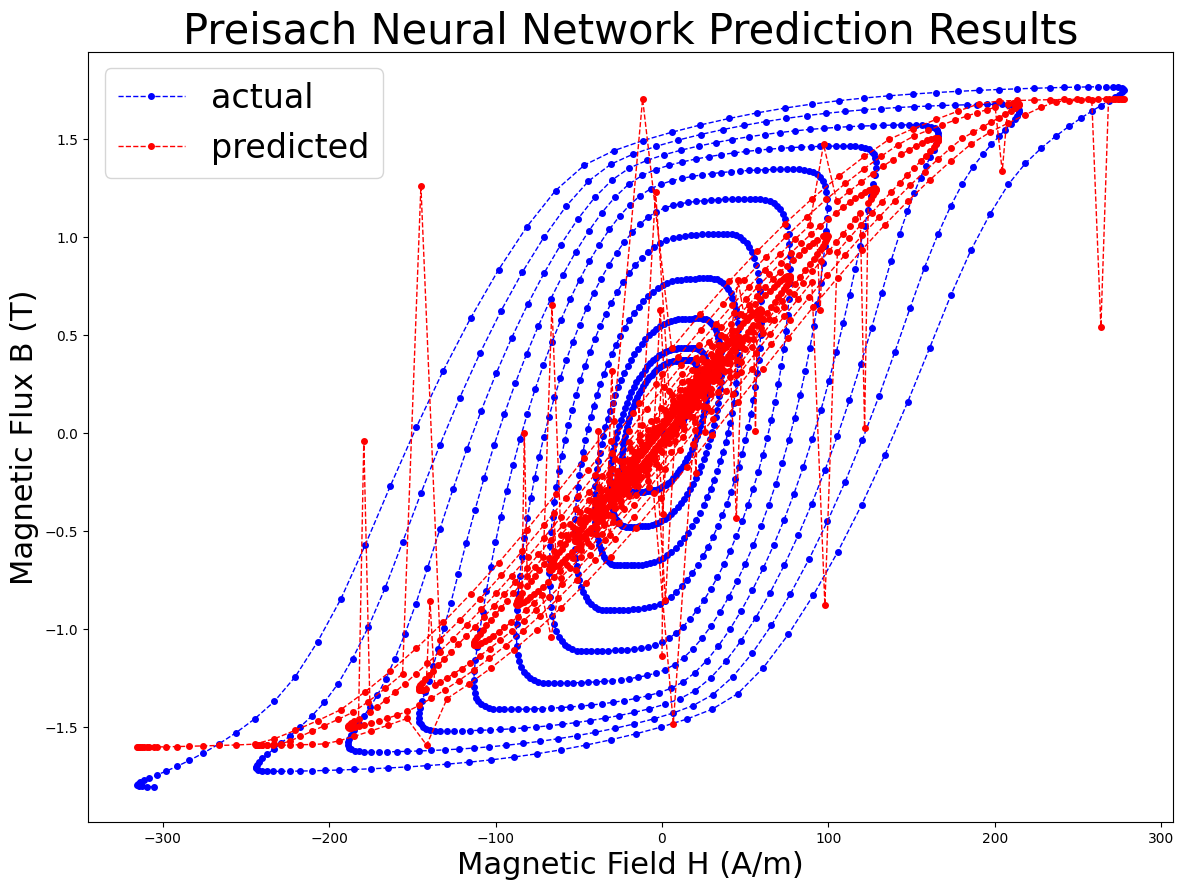

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (32, 1)                   2         
                                                                 
 stop_operator_layer (Recurr  (32, 10)                 30        
 entPreisachLayer)                                               
                                                                 
 dense_4 (Dense)             (32, 10)                  110       
                                                                 
 dense_5 (Dense)             (32, 1)                   11        
                                                                 
Total params: 153
Trainable params: 133
Non-trainable params: 20
_________________________________________________________________


In [27]:
# Evaluate and generate a plot of the RPNN
print("Output range of predicted loop should be bound between (-2, 2). Max should be something around 1.8")
rpnn_prediction = rpnn_model.predict(p_test_x[0:1152])
#plot_predicted(p_test_x[0:1152], rpnn_prediction[0:1152], "R Preisach Network (trained with {} epoch(s))".format(n))

poster_plot(p_test_x[0:1152], p_test_y[0:1152], rpnn_prediction[0:1152], "Preisach Neural Network Prediction Results", "rpnn_prediction.png")

rpnn_model.summary()


In [10]:
rpnn_model.evaluate(p_test_x[0:1152], p_test_y[0:1152])

(32, 10)
36/36 [==============================] - 1s 1ms/step - loss: 0.3689 - mean_squared_error: 0.3689 - mean_absolute_error: 0.4676


[0.3689185678958893, 0.3689185678958893, 0.467595636844635]

In [17]:
rpnn_model.layers[1].get_weights()


[array([[ 0.70677567,  0.504704  , -0.5321455 , -0.17853647,  0.37981543,
         -0.310695  ,  0.30932495, -0.29075837, -0.43772942, -0.00476266]],
       dtype=float32),
 array([ 1.,  1., -1., -1.,  1., -1.,  1., -1., -1., -1.], dtype=float32),
 array([-251.13956  , -179.33716  ,  189.08798  ,   63.43961  ,
        -134.96033  ,  110.39967  , -109.91286  ,  103.31557  ,
         155.53899  ,    1.6923211], dtype=float32)]

### Genetic Training Preisach Network
Source: https://blog.paperspace.com/train-keras-models-using-genetic-algorithm-with-pygad/

In [9]:
from custom_activation import RecurrentPreisachLayer
import tensorflow as tf
import pygad.kerasga


input_layer = tf.keras.layers.Input(1)
hidden_layer0 = tf.keras.layers.Dense(1,
                activation='linear',
                kernel_initializer=tf.keras.initializers.GlorotNormal(),
                bias_initializer=tf.zeros_initializer())(input_layer)  # input layer
hidden_layer1 = RecurrentPreisachLayer(10,
#hidden_layer1 = tf.keras.layers.Dense(10, activation='sigmoid',
                 name="stop_operator_layer",
                 use_bias=False,
                 kernel_initializer=tf.keras.initializers.GlorotNormal(),
                 bias_initializer=tf.zeros_initializer())(hidden_layer0)  # stop operator layer
hidden_layer2 = tf.keras.layers.Dense(10,
                activation='sigmoid',
                kernel_initializer=tf.keras.initializers.GlorotNormal(),
                bias_initializer=tf.zeros_initializer())(hidden_layer1)  # sigmoid layer
output_layer = tf.keras.layers.Dense(1,
                activation='linear',
                kernel_initializer=tf.keras.initializers.GlorotNormal(),
                bias_initializer=tf.zeros_initializer())(hidden_layer2)  # output layer

ga_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

weights_vector = pygad.kerasga.model_weights_as_vector(model=ga_model)
print(weights_vector)

[-1.0810276   0.          0.20771523  0.28402337  0.32879567 -0.20631999
 -0.31260523 -0.11101193  0.16511753  0.6302066  -0.02309398  0.34403905
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.29979834  0.1502753   0.6148685   0.46768272
 -0.42917144  0.03472906  0.38083732 -0.66050166  0.17762384 -0.21295361
  0.1649287  -0.44415832  0.11512169 -0.08108959  0.2582734  -0.0128082
 -0.22558501  0.63566756  0.21426317  0.56101185 -0.6102354  -0.53640497
 -0.41825917 -0.10390992 -0.52288884 -0.18230213  0.18731172  0.3759372
 -0.6217729   0.01412518  0.1014384   0.638674   -0.29619953 -0.16319211
  0.3655381  -0.17289273  0.53330415  0.4004896  -0.08940975  0.16585025
 -0.28110573  0.02443095 -0.13522442 -0.4789076   0.47593346 -0.42845687
 -0.45491043 -0.50263155 -0.2086723   0.54079604 -0.296415   -0.13065635
 -0.

In [10]:
#rpnn_untrained_model = compile_recurrent_preisach_network_without_training("untrained_model")
keras_ga = pygad.kerasga.KerasGA(model=ga_model, num_solutions=10)

print(p_train_x.shape)
print(p_train_y.shape)

#input_shape = p_train_x.shape
#rpnn_untrained_model.build(input_shape)

#rpnn_untrained_model.get_weights()

# loss function
#mae = tf.keras.losses.MeanAbsoluteError()
#loss = mae(y_true, y_pred).numpy()

(3564, 1)
(3564, 1)


In [11]:
# Fitness function
def fitness_function(solution, sol_idx):
    # data_input = p_test_x
    # data outputs = p_test_y
    # keras_ga = rpnn_ga
    # model = rpnn_untrained_model

    model_weights_matrix = pygad.kerasga.model_weights_as_matrix(
        model = ga_model,
        weights_vector=solution)

    ga_model.set_weights(weights = model_weights_matrix)

    predictions = ga_model.predict(p_test_x)

    mae = tf.keras.losses.MeanAbsoluteError()
    # fitness = inverse of loss
    solution_fitness = 1.0 / (mae(p_test_y, predictions).numpy() + 0.00000001)

    return solution_fitness


In [12]:
# generation callback function
def callback_generation(ga_instance):
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))

In [13]:
num_generations = 250
num_parents_mating = 5
initial_population = keras_ga.population_weights

print(keras_ga.population_weights)

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       initial_population=initial_population,
                       #sol_per_pop=10,
                       #num_genes=10,
                       fitness_func=fitness_function,
                       on_generation=callback_generation)

ga_instance.run()


[array([-1.0810276 ,  0.        ,  0.20771523,  0.28402337,  0.32879567,
       -0.20631999, -0.31260523, -0.11101193,  0.16511753,  0.6302066 ,
       -0.02309398,  0.34403905,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.29979834,  0.1502753 ,  0.6148685 ,
        0.46768272, -0.42917144,  0.03472906,  0.38083732, -0.66050166,
        0.17762384, -0.21295361,  0.1649287 , -0.44415832,  0.11512169,
       -0.08108959,  0.2582734 , -0.0128082 , -0.22558501,  0.63566756,
        0.21426317,  0.56101185, -0.6102354 , -0.53640497, -0.41825917,
       -0.10390992, -0.52288884, -0.18230213,  0.18731172,  0.3759372 ,
       -0.6217729 ,  0.01412518,  0.1014384 ,  0.638674  , -0.29619953,
       -0.16319211,  0.3655381 , -0.17289273,  0.53330415,  0.4

c:\users\chris\git\ecse458_plotter\venv\lib\site-packages\pygad\pygad.py:3345: UserWarning: Please use the plot_fitness() method instead of plot_result(). The plot_result() method will be removed in the future.
  warnings.warn("Please use the plot_fitness() method instead of plot_result(). The plot_result() method will be removed in the future.")


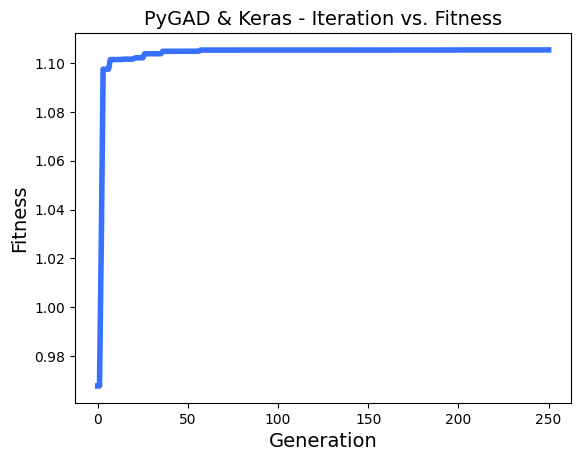

112/112 [==============================] - 0s 824us/step
Fitness value of the best solution = 1.1053805264558505
Index of the best solution : 0


In [14]:
# Visualize results
ga_instance.plot_result(title="PyGAD & Keras - Iteration vs. Fitness", linewidth=4)

# get best solution
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))


36/36 [==============================] - 0s 3ms/step
Predictions : 
 [[0.26162302]
 [0.29462624]
 [0.2946174 ]
 ...
 [0.13852644]
 [0.13852644]
 [0.13852644]]
Absolute Error :  0.9726806


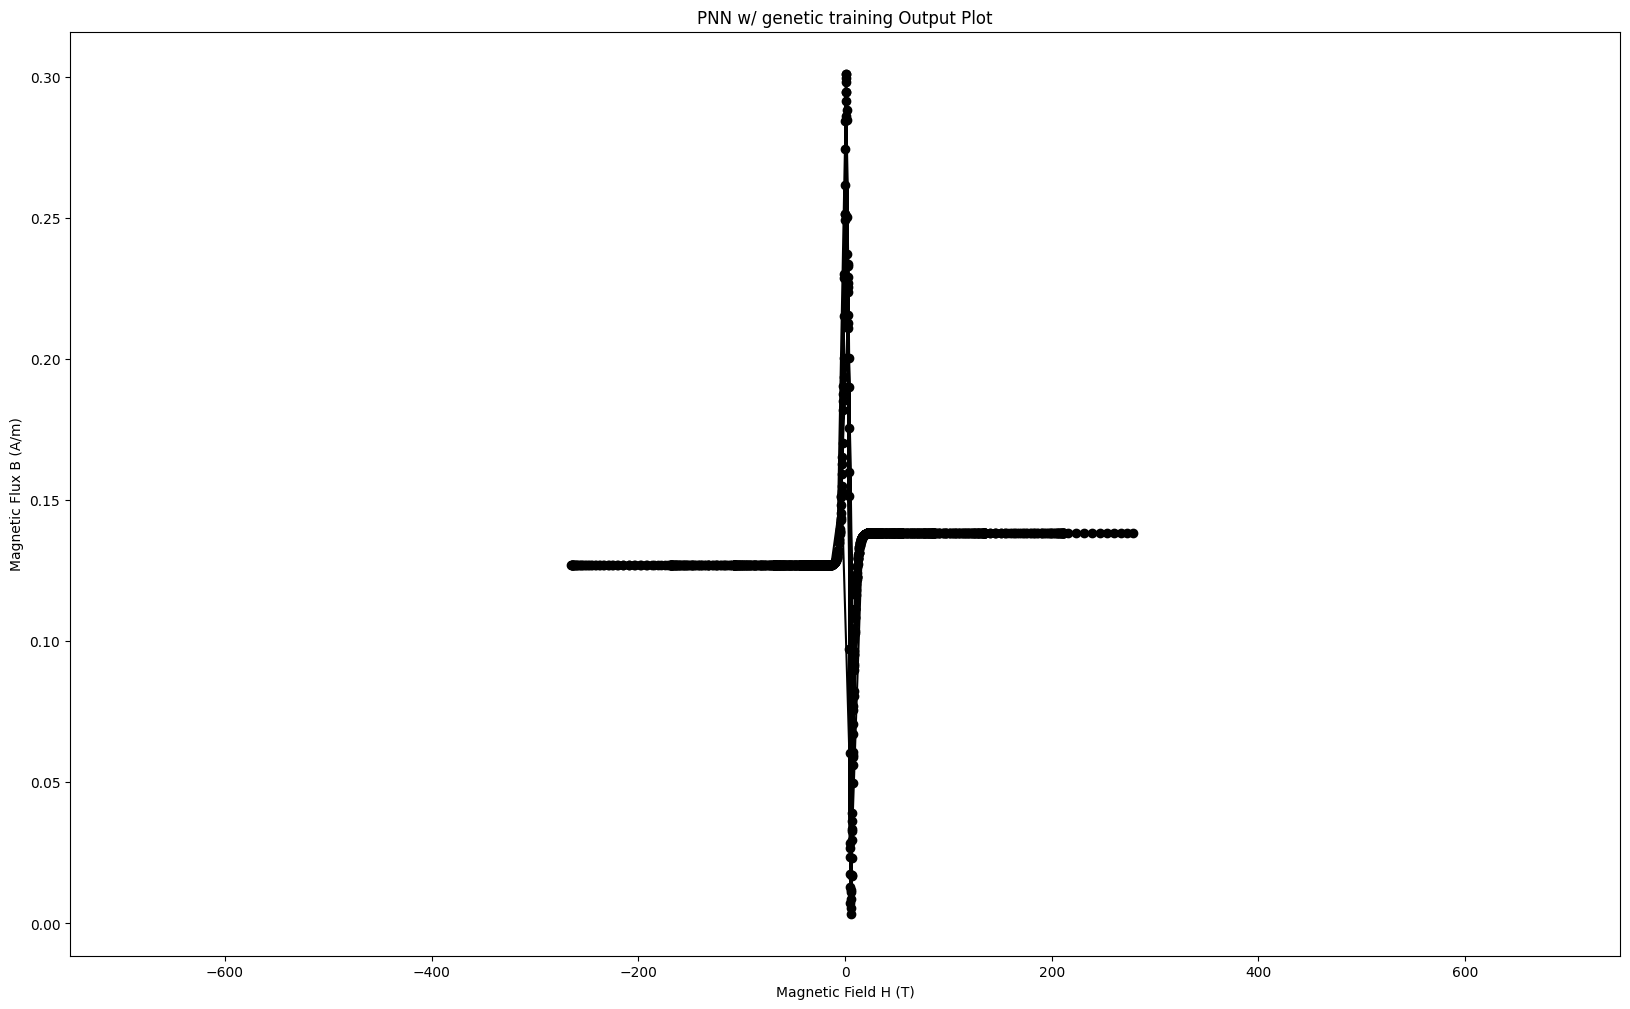

In [17]:
# Fetch the parameters of the best solution.
best_solution_weights = pygad.kerasga.model_weights_as_matrix(model=ga_model,
                                                              weights_vector=solution)
ga_model.set_weights(best_solution_weights)
predictions = ga_model.predict(p_test_x[0:1152])
print("Predictions : \n", predictions)

mae = tf.keras.losses.MeanAbsoluteError()
abs_error = mae(p_test_y[0:1152], predictions).numpy()
print("Absolute Error : ", abs_error)

plot_predicted(p_test_x[0:1152], predictions[0:1152], "PNN w/ genetic training")


## Feedforward Network

In [6]:
# Generate and train feedforward network
feedforward_model = train_and_generate_feedforward_network(train_x, train_y, "feedforward.model", n_epochs=20)

Epoch 1/20
112/112 [==============================] - 1s 2ms/step - loss: 0.4515 - mean_squared_error: 0.4515 - mean_absolute_error: 0.5416
Epoch 2/20
112/112 [==============================] - 0s 2ms/step - loss: 0.2809 - mean_squared_error: 0.2809 - mean_absolute_error: 0.4256

In [7]:
# Load feedforward model
feedforward_model = tf.keras.models.load_model("./models/feedforward.model")

In [11]:
# Evaluate feedforward network
feedforward_prediction = feedforward_model.predict(test_x)
#mse = compute_mse(test_y, feedforward_prediction)
#print("MSE: " + str(mse))

# tensorflow evaluation
feedforward_model.evaluate(test_x, test_y)

38/38 [==============================] - 0s 1ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0792


[0.011409912258386612, 0.011409912258386612, 0.07921696454286575]

In [10]:
# sklearn evaluation - same results as above, just printed in a more easily read format

from sklearn.metrics import mean_squared_error, mean_absolute_error # for model evaluation metrics

# Predict the result on training data
feedforward_pred_train = feedforward_model.predict(train_x)
# Predict the result on test data
feedforward_pred_test = feedforward_model.predict(test_x)

print('---------- Evaluation on Training Data ----------')
print("MSE: ", mean_squared_error(train_y, feedforward_pred_train))
print("MAE: ", mean_absolute_error(train_y, feedforward_pred_train))
print("")

print('---------- Evaluation on Test Data ----------')
print("MSE: ", mean_squared_error(test_y, feedforward_pred_test))
print("MAE: ", mean_absolute_error(test_y, feedforward_pred_test))
print("")

38/38 [==============================] - 0s 2ms/step
---------- Evaluation on Training Data ----------
MSE:  0.008925519753890726
MAE:  0.058057256866776076

---------- Evaluation on Test Data ----------
MSE:  0.011409908345212966
MAE:  0.07921695496412227



In [ ]:
# Plot feedforward output
#plot_predicted(test_next_h, feedforward_prediction, "Feedforward Network")

poster_plot(test_next_h, test_y, feedforward_prediction, "Feedforward Neural Network Prediction Results", "feedforward_predictions.png")

## Preisach Network

In [ ]:
# Generate and train preisach network
pnn_model = train_and_generate_preisach_network(p_train_x, p_train_y, "preisach.model", n_epochs=20)

In [ ]:
# Load preisach model
pnn_model = tf.keras.models.load_model("./models/preisach.model")

In [ ]:
#Evaluate preisach model
pnn_prediction = pnn_model.predict(p_test_x)
mse = compute_mse(p_test_y, pnn_prediction)
print("MSE: " + str(mse))

# tensorflow evaluation
pnn_model.evaluate(p_test_x, p_test_y)

In [ ]:
# Plot Preisach output
plot_predicted(p_test_x, pnn_prediction, "Preisach Network")

## Recurrent Network
no stop activation layer

In [ ]:
# Generate and train recurrent network (no stop operator)
rnn_model = train_and_generate_recurrent_network(train_x, train_y, "recurrent.model", n_epochs=20)

In [ ]:
# Load recurrent network
rnn_model = tf.keras.models.load_model("./models/recurrent.model")

In [ ]:
# Evaluate recurrent model
rnn_prediction = rnn_model.predict(test_x)
mse = compute_mse(test_y, rnn_prediction)
print("MSE: " + str(mse))

# tensorflow evaluation
rnn_model.evaluate(test_x, test_y)

In [ ]:
plot_predicted(test_next_h, rnn_prediction, "Recurrent LSTM network")